In [2]:
from torch import nn
import math
import time

class RNNModel(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.feature_size = feature_size
        self.num_hiddens = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout 
        
        self.rnn = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(self.num_hiddens, 16),
            nn.Linear(16, 1))
        
        self.val_loss_list = []  # 存储验证集每个epoch的损失
        self.train_loss_list = []  # 存储训练集每个epoch的损失
        self.min_loss = 10e6
  
    def encode(self, x_enc, state0):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_size]
        # RNN 返回为output, (h_n, c_n)  output为(时间步, bath_size , hidden_size) h_n为（num_layers, bath_size, Hidden）
        _, state = self.rnn(x_enc, state0)
        return state
        
    def decode(self, x_dec, state):
        H, state = self.rnn(x_dec, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,1)。
        y_hat = self.fc(H.reshape(-1, self.num_hiddens))
        return y_hat, state

    def forward(self, x_enc, x_dec):
        state = self.encode(x_enc)
        y_hat,_ = self.decode(x_dec, state)
        return y_hat
    
    def predict(self ,x_enc, x_dec, state0):
        # batch归一化后的值，x_enc x_dec(时间步，batch，features)
        y = []
        with torch.no_grad():
            self.eval()
            # 迭代多步，并且每次预测值替换x_dec中的真实值
            state = self.encode(x_enc, state0)
            y_hat, state = self.decode(x_dec[0, :, :].reshape(1, 1, -1), state)
            y.append(y_hat)
            for i in range(1, x_dec.shape[0]):
                # 预测值替换, 获得下一步的decode输入
                x_dec_next = x_dec[i, :, :].clone().reshape(1, 1, -1)
                x_dec_next[...,-1] = y_hat
                # 氧量不变已经处理过
                y_hat, state = self.decode(x_dec_next.reshape(1, 1, -1), state)
                y.append(y_hat)
        return torch.cat(y)
    
    
    def init_state(self, batch_size, device):
        return (torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_layers, batch_size, self.num_hiddens), device=device))
        

    def grad_clipping(self, theta):
        if isinstance(self, nn.Module):
            params = [p for p in self.parameters() if p.requires_grad]
        else:
            params = self.params
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > theta:
            for param in params:
                param.grad[:] *= theta / norm

# 初始化模型训练参数
def init_net(m):
    with torch.no_grad():
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.Conv2d):
            n = m.in_channels
            print(n)
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
        elif isinstance(m, nn.LSTM):
            stdv = 1.0 / math.sqrt(m.hidden_size)
            for weight in m.parameters():
                torch.nn.init.uniform_(weight, -stdv, stdv)
                # torch.nn.init.constant_(weight, 1)


# 评价测试集
def evaluate_mae(data_iter, net, device=None):
    net.eval()
    if device is None:
        device = list(net.parameters())[0].device
    mae_sum, n = 0.0, 0
    with torch.no_grad():
        for x_enc, x_dec, y in data_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
       
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
            n += y.numel()
    return mae_sum / n


def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_replay.pth")
        print(f'call:{val_loss}')

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/LSTMCL_replay.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False
    

# 训练模型
def train_net(net, train_iter, val_iter, optimizer, loss, device, epochs):
    net.to(device)
    net.val_loss_list = []  # 记录验证集每个epoch的损失
    net.train_loss_list = []  # 记录训练集每个epoch的损失
    for epoch in range(epochs):
        train_l_sum, train_mae_sum =  0.0, 0.0
        n, start = 0, time.time()
        for x_enc, x_dec, y in train_iter:
            # x[batch_size, time_step, features]  y[batch_size, time_step, 1]
            # trans to x[time_step, batch_size, features]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device=device)
            x_dec = x_dec.to(device=device)
            y = y.to(device=device)
            net.train()
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)
            # y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            # print(y_hat.shape, y.shape)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * (NOx_max-NOx_min)).sum().cpu().item()
                n += y.numel()
        # every epoch to do
        # 评价验证集
        val_mae = evaluate_mae(val_iter, net, device)  # 均值MAE
        net.train_loss_list.append(train_mae_sum/n)
        net.val_loss_list.append(val_mae)  # 和损失相等都为MAE这里

        # 保存最优模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, val_mae)
        if early_stop:
            break

        # 展示
        print('epoch %d, loss %.4f, train mae %.3f, test_mae %.3f, time %.2f sec'
              %(epoch, train_l_sum/n, train_mae_sum/n, val_mae, time.time()-start))

    # 保存loss
    torch.save(torch.tensor(net.val_loss_list), "loss/LSTMCL_replay_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/LSTMCL_replay_train_loss.pt")

In [3]:
import pandas as pd
import numpy as np
import torch
import random
data = pd.read_csv(r'datasets\费县建模数据424-516.csv', header=1)

In [4]:
# 解析表中数据，并合并
data40 = np.array(data.iloc[0:-1:2,1:])
print('数据集总大小',data40.shape,'采样周期为40s')
Load = data40[:, 0]
Total_coal = data40[:, 1]
O2set = data40[:, 2]
FuelAF = data40[:, 3:9]
SecA = (data40[:, 9] + data40[:, 10])/2
SecB = (data40[:, 11] + data40[:, 12])/2
SecC = (data40[:, 13] + data40[:, 14])/2
SecD = (data40[:, 15] + data40[:, 16])/2
SecE = (data40[:, 17] + data40[:, 18])/2
SecF = (data40[:, 19] + data40[:, 20])/2
Sofa =  (data40[:, 21] + data40[:, 22] + data40[:, 23] + data40[:, 24])/4
NOxsample = (data40[:, 26] + data40[:, 27])/2
NOx = data40[:, -1]

数据集总大小 (45900, 38) 采样周期为40s


In [5]:
# 归一化
# 对数据归一化到[0,1] 
Load_max = 630
Load_min = 260
NOx_max = 650
NOx_min = 150
Sec_max = 100
Sec_min = 0
Sofa_max = 100
Sofa_min = 30
O2_max = 8
O2_min = 1.2
Fuel_max = 100
Fuel_min = 0

Load = (Load - Load_min)/(Load_max - Load_min)
O2set = (O2set - O2_min)/(O2_max - O2_min)
FuelAF = (FuelAF -Fuel_min)/(Fuel_max - Fuel_min)
SecA = (SecA - Sec_min)/(Sec_max - Sec_min)
SecB = (SecB - Sec_min)/(Sec_max - Sec_min)
SecC = (SecC - Sec_min)/(Sec_max - Sec_min)
SecD = (SecD - Sec_min)/(Sec_max - Sec_min)
SecE = (SecE - Sec_min)/(Sec_max - Sec_min)
SecF = (SecF - Sec_min)/(Sec_max - Sec_min)
Sofa = (Sofa- Sofa_min)/(Sofa_max - Sofa_min)
NOx = (NOx - NOx_min)/(NOx_max - NOx_min)

variables = np.zeros((len(NOx), 16))
variables[:,0] = Load  # 负荷状态
variables[:,1] = O2set  # 省煤器出口氧量设定值
variables[:,2:8] = FuelAF  # 各个给煤机给煤量
variables[:,8] = SecA  # 风门开度
variables[:,9] = SecB
variables[:,10] = SecC
variables[:,11] = SecD
variables[:,12] = SecE
variables[:,13] = SecF
variables[:,14] = Sofa 
variables[:,15] = NOx  # NOx自回归项
print('时间序列', variables.shape)

# # 估计均值与方差
# std = variables[0:8000,:].std(0)
# mean = variables[0:8000,:].std(0)
# print(std.shape, mean.shape)
# # 对数据集标准化，前15个操作量，考虑到NOx非平稳，后面做batch_norm
# variables[:,0:15] = (variables[:,0:15]-mean[0:15])/std[0:15]

时间序列 (45900, 16)


In [6]:
data_len = variables.shape[0] 
st = 50
ed = 8000
Y = NOx[st:ed].reshape(-1,1)  # 对应时刻的预测目标
delays = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # 共计16个变量，每个变量的迟延时间
orders = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]    # 共计16个变量，每个变量的输入阶数

X = np.zeros((ed-st,sum(orders)))
count = 0;
for i in range(len(delays)):
    delay = delays[i]
    order = orders[i]
    for j in range(order):
        X[:,count] = variables[st-delay-j:ed-delay-j,i]
        count += 1
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
print(f'X维度{X.shape} \tY维度{Y.shape}')
print(X[1:,-1] == Y[:-1].reshape(-1))
print(X[100,14] == variables[100+st-1,14])

X维度torch.Size([7950, 16]) 	Y维度torch.Size([7950, 1])
tensor([True, True, True,  ..., True, True, True])
tensor(True)


In [9]:
def random_iter(x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
    offset = random.randint(0, stride)  # 随机开始
    initial_indices = (np.arange(offset, len(x_train) - enc_time_step - dec_time_step, stride))  # 样本开始索引
    random.shuffle(initial_indices)  # 随机打断样本开始索引

    # 注意的是，y_train值已经前向推进了一步
    def data(pos, sign):
        if sign == 1:
            return x_train[pos:pos + enc_time_step]
        if sign == 2:
            x_dec = x_train[pos + enc_time_step:pos + enc_time_step + dec_time_step].clone()
            # 第一维保持不变    # dec中负荷保持常数
            x_dec[1:, 0] = x_dec[0, 0]
            return x_dec
        if sign == 3:
            return y_train[pos + enc_time_step:pos + enc_time_step + dec_time_step]

    num_batches = len(initial_indices) // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x_enc = torch.stack([data(j, 1) for j in initial_indices_per_batch])
        x_dec = torch.stack([data(j, 2) for j in initial_indices_per_batch])
        y = torch.stack([data(j, 3) for j in initial_indices_per_batch])
        # 对 NOx 归一化 仅batch
#         nox_mean = x_enc[:, :, -1].mean(1)
#         nox_std = x_enc[:, :, -1].std(1)
        
#         x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/(nox_std.reshape(-1, 1)+1e-6)
#         y = (y - nox_mean.reshape(-1, 1, 1))/(nox_std.reshape(-1, 1, 1)+1e-6)
        yield x_enc, x_dec, y


class RandomDataLoader:
    def __init__(self, x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
        self.x_train, self.y_train = x_train, y_train
        self.batch_size = batch_size
        self.enc_time_step, self.dec_time_step, self.stride = enc_time_step, dec_time_step, stride

    def __iter__(self):
        return random_iter(self.x_train, self.y_train, self.batch_size,
                                self.enc_time_step, self.dec_time_step, self.stride)

    

def split(X, Y, test_size=0.25):
    train_num = int(len(X)*(1-test_size))
    X_train = X[:train_num,]
    y_train = Y[:train_num,]
    X_test = X[train_num:,]
    y_test = Y[train_num:,]
    return X_train, X_test, y_train, y_test



x_train, x_val, y_train, y_val = split(X, Y, test_size=0.25)
print(f'X_train.shape: {x_train.shape}, X_val.shape:{x_val.shape}')

seed = 42
random.seed()
batch_size = 128
encoder_len = 20
decoder_len = 15
stride = 1
train_dl = RandomDataLoader(x_train, y_train, batch_size, encoder_len, decoder_len, stride)
val_dl = RandomDataLoader(x_val, y_val, batch_size, encoder_len, decoder_len, stride)

for x_enc, x_dec, y in train_dl:
    print('x_enc.shape', x_enc.shape, '\tx_dec.shape', x_dec.shape, '\ty.shape', y.shape)
    break

X_train.shape: torch.Size([5962, 16]), X_val.shape:torch.Size([1988, 16])
x_enc.shape torch.Size([128, 20, 16]) 	x_dec.shape torch.Size([128, 15, 16]) 	y.shape torch.Size([128, 15, 1])


### 如何由varibles_subset到train_dl? 测试代码

In [7]:
# variables_subset = variables[100-1:8000+100,:]
# x_train = torch.tensor(variables_subset[0:-1,:], dtype=torch.float32)
# y_train = torch.tensor(variables_subset[1:,-1], dtype=torch.float32)  # 对应时刻的预测目标

# seed = 42
# random.seed()  # 不使用random_seed
# batch_size = 128
# encoder_len = 20
# decoder_len = 15
# stride = 1
# train_dl = RandomDataLoader(x_train, y_train, batch_size, encoder_len, decoder_len, stride)
# for x_enc, x_dec, y in train_dl:
#     print('x_enc.shape', x_enc.shape, '\tx_dec.shape', x_dec.shape, '\ty.shape', y.shape)
#     break

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=32, num_layers=2, dropout=0.4)
net.to(dtype=torch.float32, device=device)
net.apply(init_net)

loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 100
# train_net(net, train_dl, val_dl, optimizer, loss, device, epochs)

training on cuda


### 在线更新时重新训练模型，并设置epoch为固定值
mean: tensor(1.6997) std: tensor(1.4791)

In [21]:
def grad_clipping(grad, theta):
    """MAS每个网络权重 分别裁剪"""
    norm = (grad ** 2).sum().sqrt()
    if norm > theta:
         grad *= theta / norm
    return grad

class Buffer:
    def __init__(self, num_sample, encoder_len, decoder_len, time_decay=1, batch_size=128):
        super().__init__()
        self.num_sample = num_sample  # Buffer 大小
        self.encoder_len = encoder_len  
        self.decoder_len = decoder_len
        self.time_decay = time_decay  # 时间权重衰减因子
        self.upstate = False  # 更新状态
        self.upstate_num = 0  # 更新次数
        self.batch_size = batch_size
        self.variables = None
        self.weight = None
        self.train_dl = None
        
        self.y_hat_buffer = None  # 记录15步预测结果15*15 15个时刻，每个时刻15步
        self.y_true_buffer = None  # 记录15步观测值
        
        self.time_decay=0.99
        
        self.MASomegas = []  # 保存每次样本到来且满足阈值条件时的 重要性权重
        self.alpha_omegas = 0.99 #  omegas衰减xis
        self.regular_lambda = 10
        self.parameters_star = []  # 保存每次模型更新后的模型参数

    def init_buffer(self, before_time, variables, net):
        '''
        before_time： 只能使用这之前的数据初始化buffer，不包括before_time， 因为之后的数据不能满足decoder_len
        '''
        device = list(net.parameters())[0].device
        # 初始化buffer样本库
        self.variables = variables[before_time-self.num_sample:before_time,:].copy()
        # input_size = variables.shape[1]
        
        self.y_hat_buffer = torch.zeros((decoder_len,decoder_len))
        self.y_true_buffer = torch.zeros(decoder_len)
        
        # 初始化MAS的重要性权重omegas
        # 初始化parameters_star
        for pindex, p in enumerate(net.parameters()):
            # self.MASomegas = [torch.zeros_like(p, device=device, dtype=torch.float32) for p in net.parameters()]
            self.parameters_star = [p.data.clone().detach() for p in net.parameters()]
        # 初始化时间衰减权重
        self.weight = np.ones((self.num_sample))
        for i in range(self.num_sample):
            self.weight[i] = 1 if i==0 else self.weight[i-1]*self.time_decay
        
        # 初始化train_dl
        self.to_dataloder()  

    def to_dataloder(self):
        x_train = torch.tensor(self.variables[0:-1,:], dtype=torch.float32)
        y_train = torch.tensor(self.variables[1:,-1], dtype=torch.float32)  # 对应时刻的预测目标
        assert (x_train[1:,-1] == y_train[:-1].reshape(-1)).all()
        # seed = 42
        random.seed()  # 不使用random_seed
        self.train_dl = RandomDataLoader(x_train=x_train, y_train=y_train, batch_size=self.batch_size, 
                                         enc_time_step=self.encoder_len, dec_time_step=self.decoder_len, stride=1)
 
    def insert(self, variables_t):
        self.variables[0:self.num_sample-1,:] = self.variables[1:self.num_sample,:]  # 时间窗先前滑动1位
        self.variables[-1,:] = variables_t  #  ...,t-2,t-1,t最后为当前时刻
        
        self.y_true_buffer[0:-1] = self.y_true_buffer[1:].clone()
        self.y_true_buffer[-1] = variables_t[-1]  # 最后一个pos记录当前值
        
    def MASomegas_update(self, net):
        '''
        计算重要性权重g,即F对每个参数theta的偏导数，并采用时间衰减更新MASomegas
        利用buffer中的数据计算，latest one training sample
        '''
        device = list(net.parameters())[0].device
        # 构造样本 x_enc，x_ed， y_pred, 单个batch  构造t时刻预测样本
        # torch.set_printoptions (precision=6) 
        y = torch.tensor(self.variables[-self.decoder_len:, -1])  # (time_step=15)  至少需要36个时刻初始化一个训练样本
        x_dec = torch.tensor(self.variables[-self.decoder_len-1:-1]).unsqueeze(0)  # (1,time_step=15, feature_size)
        x_enc = torch.tensor(self.variables[-self.decoder_len-1-self.encoder_len:-self.decoder_len-1]).unsqueeze(0)  # (1,time_step=20, feature_size)
        assert (x_dec[:,1:,-1] == y[:-1]).all()
        x_enc.transpose_(0, 1)
        x_dec.transpose_(0, 1)
        x_enc = x_enc.to(device=device, dtype=torch.float32)
        x_dec = x_dec.to(device=device, dtype=torch.float32)
        # print(x_enc.shape, x_dec.shape, y.shape)
        # 15步前向预测，采用训练方式，即非迭代方式
        state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
        # 计算Y对每个参数的梯度
        gradients=[]  # 用来保存单个样本在线更新时的梯度
        net.zero_grad()
        net.train()
        state = net.encode(x_enc, state0)
        y_hat,_ = net.decode(x_dec, state);  # 预测结果，但是与训练时一致
        torch.norm(y_hat, 2).backward() # L2范数求和，并后向传播
        # 保存grad
        for pindex, p in enumerate(net.parameters()):
            g=p.grad.data.clone().detach().abs()
            # grad_clipping(g, theta=0.1)
            gradients.append(g)  # 裁剪后的梯度
        net.zero_grad()
        # 计算每个参数的重要性权重，保存模型参数发生在更新之后
        omegas_old = self.MASomegas[:]  # 临时变量
        # self.MASomegas = []
        for pindex,p in enumerate(net.parameters()):
            if len(omegas_old) != 0:   
                self.MASomegas[pindex] = self.alpha_omegas*gradients[pindex]+(1-self.alpha_omegas)*omegas_old[pindex]
            else: # 初始化omegas
                self.MASomegas.append(gradients[pindex])
    
    @property
    def time_decay_sample_index(self):
        '''
        说明：按照时间概率衰减的方式抽样进行replay，其中越接近当前时刻概率越高
        '''
        # 抽样概率设计1->500逐渐降低，累计为1
#         p_linear = np.arange(self.num_sample,0,-1)
#         p_linear = p_linear/sum(p_linear)
        p_equal = np.ones((self.num_sample))/self.num_sample
        sample_index = np.random.choice(np.arange(num_sample), replace=False, size=self.batch_size, p=p_equal)
        return sample_index
    
    def __getitem__(self, index):
        '''
        '''
        sample_index = self.time_decay_sample_index
        if index == 0:
            return self.x_enc[sample_index,...]
        elif index == 1:
            return self.x_dec[sample_index,...]
        elif index == 2:
            return self.y[sample_index,...]
        else:
            assert False
        

'''
buffer 中存储连续历史样本5000个，即variables_subset[0:5000]
根据variables_subset构造x_train, y_trian -> train_dl
采用train_dl微调net，并固定epoch为一定值
'''

# st_test = ed  # 开始测试时刻
# ed_test = ed+20000 # 预测步长是15
st_test = 50  # ed  # 开始投喂的时刻为50
ed_test = data_len - 50  # 结束投喂的时刻为45850
y_pred = torch.zeros((ed_test-st_test, decoder_len))  # 保存预测结果
y_true = torch.zeros((ed_test-st_test, decoder_len))  # 保存对应的真实值

# 开始在更新训练 # 模型准备 # 加载最优模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
net = RNNModel(feature_size=16, hidden_size=64, num_layers=2, dropout=0.4)
net.load_state_dict(torch.load("model/LSTMCL_base.pth"))
net.to(dtype=torch.float32, device=device)
loss = nn.L1Loss(reduction ='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)
epochs = 1
one_step_error = 0  # 单步预测误差
threshold_onestep = 1.6997 + 1*1.4791  # 更新阈值判断标准
threshold_mutistep = 158.8248 + 1*149.8840  # 更新阈值判断标准

# 初始化buffer，保存N=5000个最近的样本，同时利用训练数据初始化，主动策略，
num_sample = 1000
before_time=8000  # 测试样本在8000之后
buffer = Buffer(num_sample=num_sample, encoder_len=encoder_len, 
                decoder_len=decoder_len, time_decay=1, batch_size=128)
buffer.init_buffer(before_time=before_time, variables=variables, net=net)

training on cuda


In [23]:
import time
def online_predict(t, net, variables, NOx_max, NOx_min):
    # 获得t时刻各个变量的采样值，使用t-19，t-18，...,t时刻数据，预测未来t+1，t+2,...t+15时刻NOx
    # 构造样本 x_enc，x_ed， y_pred, 单个batch
    x_enc = torch.tensor(variables[t-encoder_len:t]).unsqueeze(0)  # (1,time_step=20, feature_size)
    x_dec = torch.tensor(variables[t:t+decoder_len]).unsqueeze(0)  # (1,time_step=15, feature_size)
    y = torch.tensor(variables[t+1:t+decoder_len+1, -1])  # (time_step=15)
    #     对NOx batch_norm
    #     nox_mean = x_enc[:, :, -1].mean(1)
    #     nox_std = x_enc[:, :, -1].std(1)
    #     x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    #     x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
    #     y = (y - nox_mean)/nox_std
    x_enc.transpose_(0, 1)
    x_dec.transpose_(0, 1)
    x_enc = x_enc.to(device=device, dtype=torch.float32)
    x_dec = x_dec.to(device=device, dtype=torch.float32)
    # print(x_enc.shape, x_dec.shape, y.shape)
    # 迭代15步前向预测
    state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
    net.eval()
    y_hat = net.predict(x_enc, x_dec, state0).cpu()  # 返回一个15时间步的预测结果
    # 返回到原始空间中
    y_hat = y_hat*(NOx_max-NOx_min) + NOx_min
    y = y*(NOx_max-NOx_min) + NOx_min
    return y_hat.reshape(-1), y

# 训练模型
def train_net_cl(net, buffer, optimizer, loss, device, epochs, regularization=False):
    net.to(device)
    net.train_loss_list = []  # 记录训练集每个epoch的损失，即对应每次更新时的损失
    start = time.time()
    if regularization:
        for pindex, p in enumerate(net.parameters()):
            buffer.parameters_star[pindex] = p.data.clone().detach()  # 保存此时的模型参数，用来构造MASloss
    for epoch in range(epochs):
        train_l_sum, train_mae_sum = 0.0, 0.0
        n = 0
        for x_enc, x_dec, y in buffer.train_dl:
            # x[batch_size, time_step, features]  y[batch_size, time_step, 1]
            # trans to x[time_step, batch_size, features]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device=device)
            x_dec = x_dec.to(device=device)
            y = y.to(device=device)
            net.train()
            state0 = net.init_state(batch_size=x_enc.shape[1], device=device)
            state = net.encode(x_enc, state0)
            y_hat,_ = net.decode(x_dec, state)
            # y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            # print(y_hat.shape, y.shape)
            total_loss = loss(y_hat.reshape(-1), y.reshape(-1))
            # add MAS regularization to the training objective
            if regularization:
                for pindex, p in enumerate(net.parameters()):
                    total_loss += buffer.regular_lambda*torch.sum(buffer.MASomegas[pindex]*(p-buffer.parameters_star[pindex])**2)
            total_loss.backward()
            # 增加梯度裁剪，防止单步学习步长过大
            # net.grad_clipping(theta=0.1)
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                train_l_sum += total_loss.detach().cpu().item()
                n += y.numel()
        net.train_loss_list.append(train_l_sum/n)

y_hat = torch.tensor(variables[st_test:st_test+15,-1]*(NOx_max-NOx_min) + NOx_min)  # 仅初始化    
y = torch.tensor(variables[st_test:st_test+15,-1]*(NOx_max-NOx_min) + NOx_min)
buffer.init_buffer(before_time=before_time, variables=variables, net=net)

update_timestamp = []
net.train_loss_list = []
for t in range(st_test, ed_test):
    '''
    获得t时刻数据，更新Buffer，更新net，获得多步预测结果[t+1:t+decoder_len]，并留用于之后的评价中
    '''
    buffer.insert(variables_t=variables[t,:])  # 送入当前时刻的采样数据
    yt_observer = variables[t,-1]*(NOx_max-NOx_min) + NOx_min  # t时观察到的单步预测结果
    muti_step_error = (buffer.y_true_buffer*(NOx_max-NOx_min) + NOx_min - buffer.y_hat_buffer[0,:]).abs().sum()
    assert yt_observer==y[0]
    one_step_error = np.abs((y_hat[0] - yt_observer))  # 单步预测误差
    # buffer.upstate = True if (one_step_error>threshold) else False
    
    # 根据t-1时刻的单步预测结果y_hat(t)，判断是否更新模型，仅对测试集执行
    if (t>ed) & (one_step_error>threshold_onestep):
        time_recoder = time.time()
        # net.apply(init_net)  # 初始化权重，重新训练
        buffer.to_dataloder()  # 利用buffer中样本构造  train_dl
        train_net_cl(net, buffer, optimizer, loss, device, epochs)  # 微调网络
        time_ender = time.time()
        print(time_ender-time_recoder)
        buffer.upstate_num += 1  # 记录更新次数
        update_timestamp.append(t)

    # 如果预测误差较小，更新MASomegas
#     if (t>st_test+40) & (muti_step_error>threshold_mutistep):  # buffer中需要至少初始化一段样本，才能满足构造latest one training samples的条件
#         buffer.MASomegas_update(net)  # 更新MASomegas
    '''
    评价更新结果，当前时刻(t时刻)进行前向15步预测 
    '''
    y_hat[:], y[:] = online_predict(t, net, variables, NOx_max, NOx_min)  # 返回的维度都为torch.Size([15])
    # 单步预测误差判断是否更新？ 这一步应该放在t+1时刻进行判断
    # 保存多步预测结果
    buffer.y_hat_buffer[0:-1,:] = buffer.y_hat_buffer[1:,:].clone()  # 时间窗先前滑动1位
    buffer.y_hat_buffer[-1,:] = y_hat  #  ...,t-2,t-1,t最后为当前时刻
    
    y_pred[t-st_test,:] = y_hat
    y_true[t-st_test,:] = y
    if (t-st_test)%500==0: print('采样次数(40s):{}\t更新次数:{}'.format(t-st_test,buffer.upstate_num))
    if (t-st_test)%200==0: print('单步误差：{}'.format(one_step_error))
#     if t == st_test+15:
#         break

采样次数(40s):0	更新次数:0
单步误差：0.0
单步误差：0.7167587710937369
单步误差：0.3167523617187271
采样次数(40s):500	更新次数:0
单步误差：5.153010660156269
单步误差：1.6001359730468607
采样次数(40s):1000	更新次数:0
单步误差：0.2391401910156219
单步误差：0.9236746249999896
单步误差：1.3472135683593933
采样次数(40s):1500	更新次数:0
单步误差：0.6209501531250226
单步误差：0.74637635859375
采样次数(40s):2000	更新次数:0
单步误差：0.8672755289062479
单步误差：1.201542444531242
单步误差：0.928511372265632
采样次数(40s):2500	更新次数:0
单步误差：0.9236031664062239
单步误差：0.14492905859373195
采样次数(40s):3000	更新次数:0
单步误差：2.8265136460937583
单步误差：0.12274519375000637
单步误差：1.3624802871093493
采样次数(40s):3500	更新次数:0
单步误差：1.104028205078123
单步误差：1.3263219851562553
采样次数(40s):4000	更新次数:0
单步误差：0.23747863046872908
单步误差：0.8886693351562371
单步误差：1.1003637957031174
采样次数(40s):4500	更新次数:0
单步误差：1.2612503324218665
单步误差：5.388295408203135
采样次数(40s):5000	更新次数:0
单步误差：1.381039224218739
单步误差：1.3471397441406339
单步误差：0.8759627603515696
采样次数(40s):5500	更新次数:0
单步误差：1.550225086523426
单步误差：4.871658941406224
采样次数(40s):6000	更新次数:0
单步误差：0.7422857296874

KeyboardInterrupt: 

### 训练设置，保存预测结果，最为简单的rehearsal在线更新方式

### LSTMCL_replay_naive_1
1.在初始化模型LSTMCL_base的基础上训，该模型已经过超参数寻优。\
2.buffer大小为5000，更新阈值设置为threshold = 1.6997 + 1*1.4791\
3.每次更新模型将采用buffer中的连续数据构造训练集，将模型再训练1个epoch|

结果：在线更新次数685/37850次，0-7h显著提高，之后性能反而下降

### LSTMCL_replay_naive_2
1.在初始化模型LSTMCL_base的基础上训，该模型已经过超参数寻优。\
2.buffer大小为5000，更新阈值设置为threshold = 1.6997 + 2*1.4791\
3.每次更新模型将采用buffer中的连续数据构造训练集，将模型再训练1个epoch|

结果：在线更新次数685/37850次

In [1]:
# torch.save(torch.tensor(update_timestamp), "result/LSTM_replay_naive_s1000_y_timestamp.pt")  # 更新时间戳
# torch.save(torch.tensor(net.train_loss_list), "result/LSTM_replay_naive_s1000_y_train_loss_list.pt")  # 每次更新的训练集损失
# torch.save(y_pred, "result/LSTM_replay_naive_s1000_y_pred.pt")
# torch.save(y_true, "result/LSTM_replay_naive_s1000_y_true.pt")
import torch
import numpy as np
y_true = torch.load("result/LSTM_replay_naive_s1000_y_true.pt")
y_pred = torch.load("result/LSTM_replay_naive_s1000_y_pred.pt") 
print(y_true.shape, y_pred.shape)

torch.Size([45800, 15]) torch.Size([45800, 15])


In [14]:
len(torch.load("result/LSTM_replay_naive_s1000_y_timestamp.pt"))

1813

In [8]:
np.mean([0.06396794319152832,0.06244254112243652,0.06328272819519043,0.07356429100036621,0.0783689022064209])

0.06832528114318848

### 指标评价
计算各个预测步数下的mape和mae\
设置window_len=300，统计平均结果

In [2]:
def mape(y_pred, y_true):
    loss = ((y_pred - y_true).abs() / (y_true.abs() + 1e-8))*100
    return loss

def mae(y_pred, y_true):
    loss = (y_pred - y_true).abs()
    return loss

mape = mape(y_pred, y_true)
mae = mae(y_pred, y_true)
print(mape.shape, mae.shape)

# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 300
s, h = mape.shape
mape_window = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mape_window[i, :] = mape[i*window_len:i*window_len+window_len,:].mean(0)
print(mape_window.shape)

torch.Size([45800, 15]) torch.Size([45800, 15])
(152, 15)


In [4]:
# train_len = x_train.shape[0]
# val_len = x_val.shape[0]
train_len = 5962
val_len = 1988

train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]
window_len = 300
mape_test = mape[test_st:,:] 
mae_test = mae[test_st:,:] 
# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 5000
s, h = mape_test.shape
mape_window_mean = np.zeros((s//window_len, h))
mape_window_std = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mape_window_mean[i, :] = mape_test[i*window_len:i*window_len+window_len,:].mean(0)
    mape_window_std[i, :] = mape_test[i*window_len:i*window_len+window_len,:].std(0)
print(mape_window.shape)
index = [0,6,13]
np.set_printoptions (precision=2, suppress=True) 
for i in index:
    print('预测步数{:.3f}, mape_mean:{}'.format(i+1, mape_window_mean[:,i]))
    print('预测步数{:.3f}, mape_std:{}'.format(i+1, mape_window_std[:,i]))
# np.save('result/LSTM_replay_naive_1_mape_window_mean.npy',mape_window_mean)
# np.save('result/LSTM_replay_naive_1_mape_window_std.npy',mape_window_std)

(152, 15)
预测步数1.000, mape_mean:[0.5  0.48 0.39 0.43 0.41 0.32 0.39]
预测步数1.000, mape_std:[0.49 0.49 0.39 0.45 0.6  0.32 0.61]
预测步数7.000, mape_mean:[4.95 5.97 5.17 5.19 5.68 4.9  5.24]
预测步数7.000, mape_std:[4.16 5.18 4.56 4.94 6.6  4.56 4.43]
预测步数14.000, mape_mean:[ 9.68 14.31 13.01 12.62 14.09 13.56 13.05]
预测步数14.000, mape_std:[ 8.42 12.6  10.8  11.39 14.06 12.81 10.35]


In [5]:
# 绘制MAE，MAPE多步随时间变化情况,采用窗口求统计平均
window_len = 5000
s, h = mae_test.shape
mae_window_std = np.zeros((s//window_len, h))
mae_window_mean = np.zeros((s//window_len, h))
for i in range(s//window_len):
    mae_window_mean[i, :] = mae_test[i*window_len:i*window_len+window_len,:].mean(0)
    mae_window_std[i, :] = mae_test[i*window_len:i*window_len+window_len,:].std(0)
index = [0,6,13]
np.set_printoptions(precision=2, suppress=True) 
for i in index:
    print('预测步数{}, mae_mean: {}'.format(i+1, mae_window_mean[:,i]))
    print('预测步数{}, mae_std: {}'.format(i+1, mae_window_std[:,i]))

np.save('result/LSTM_replay_naive_1_mae_window_mean.npy',mae_window_mean)
np.save('result/LSTM_replay_naive_1_mae_window_std.npy',mae_window_std)

预测步数1, mae_mean: [1.56 1.56 1.09 1.14 1.31 1.06 1.06]
预测步数1, mae_std: [1.51 1.95 1.07 1.46 1.83 0.99 1.16]
预测步数7, mae_mean: [15.39 19.16 15.2  14.24 18.34 15.94 15.13]
预测步数7, mae_std: [12.93 17.64 14.11 15.55 19.12 13.8  12.28]
预测步数14, mae_mean: [30.09 45.97 38.83 34.67 45.18 43.34 38.7 ]
预测步数14, mae_std: [26.49 41.19 34.37 34.35 40.46 36.55 31.71]


### 性能随时间变化曲线

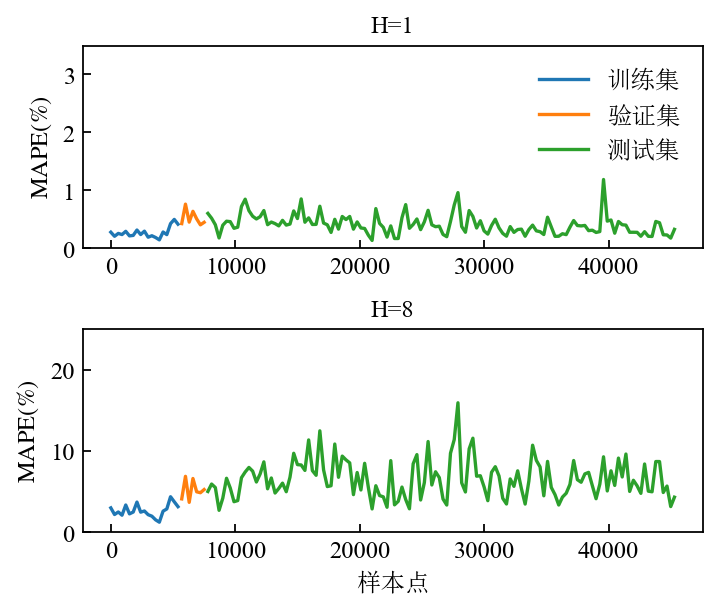

In [6]:
# 绘图
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

# create figure
config = {
"font.family":'serif',  
"font.size": 11,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}
# 画板设置
font_size = 11
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(6/1.2, 5/1.2))
# 绘图曲线
window_len = 300
train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]

train_st, train_ed, val_st, val_ed, test_st, test_ed = [int(i/window_len) for i in [train_st, train_ed, val_st, val_ed, test_st, test_ed]]
h = 0 # 预测步数
ax = fig.add_subplot(211)
ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
ax.set_ylim([0,3.5])
ax.set_title("H=1",fontsize=font_size)
ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
legend_font = {"family":"SimSun", "size":11}
plt.legend(['训练集', '验证集','测试集'],frameon=False, prop=legend_font)  # ncol=3,  bbox_to_anchor=(0.98, 1.05)

h = 7 # 预测步数
ax = fig.add_subplot(212)
ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
ax.set_ylim([0,25])
ax.set_title("H=8",fontsize=font_size)
# ax = fig.add_subplot(313)
# h = 13 # 预测步数
# ax.plot(np.arange(train_st,train_ed)*window_len, mape_window[train_st:train_ed,h], color=color_list[1], linestyle='-')
# ax.plot(np.arange(val_st,val_ed)*window_len, mape_window[val_st:val_ed,h], color=color_list[2], linestyle='-')
# ax.plot(np.arange(test_st,test_ed)*window_len, mape_window[test_st:test_ed,h], color=color_list[3], linestyle='-')
# ax.set_ylabel('$\mathrm{MAPE(\%)}$', fontfamily="SimSun", fontsize=font_size)
ax.set_xlabel('样本点', fontfamily="SimSun", fontsize=font_size)

plt.subplots_adjust(left=None, bottom=0.15, right=None, top=None, wspace=0.1, hspace=0.4)#wspace 子图横向间距， hspace 代表子图间的纵向距离，left 代表位于图像不同位置

In [7]:
def MAPE(y_pred, target):
    loss = ((y_pred - target).abs() / (target.abs() + 1e-8)).mean(0)*100
    return loss

def MAE(y_pred, target):
    loss = (target - y_pred).abs().mean(0)
    return loss
y_true = torch.load("result/LSTM_replay_naive_s1000_y_true.pt")
y_pred = torch.load("result/LSTM_replay_naive_s1000_y_pred.pt")   
train_st = 0
train_ed = train_st + train_len
val_st = train_ed
val_ed = train_ed + val_len
test_st = val_ed
test_ed = y_pred.shape[0]

test_multi_step_mae =  MAE(y_pred[test_st:test_ed], y_true[test_st:test_ed])
test_multi_step_mape = MAPE(y_pred[test_st:test_ed], y_true[test_st:test_ed])
index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net1 MAE:[1.2161601781845093, 8.729094505310059, 27.638694763183594, 40.95450973510742], mean:20.25008773803711
net1 MAPE:[0.40775445103645325, 2.889723300933838, 9.12900447845459, 13.52417278289795], mean:6.691162586212158


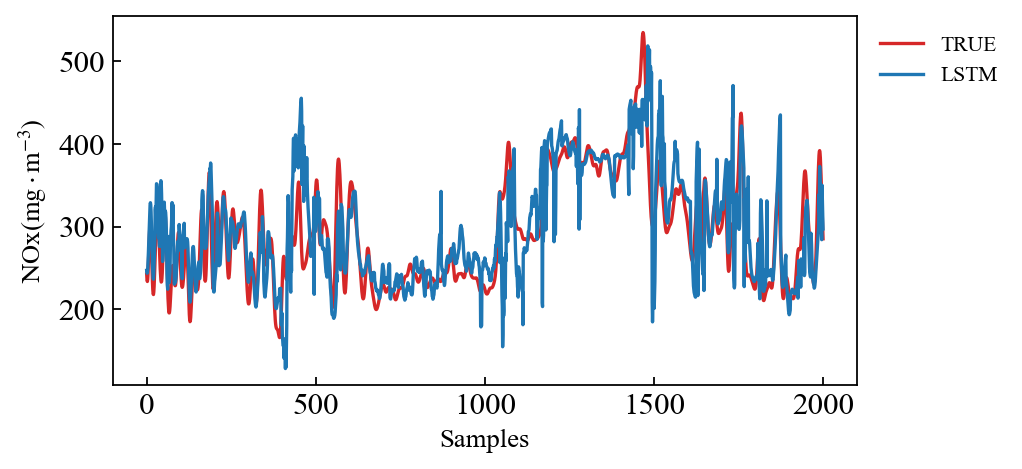

In [35]:
## 画图
## 画图
config = {
"font.family":"times new roman",    
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)

h = 10
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(6,3))
plt.plot(y_true[12000:14000,h],color = color_list[4],linewidth=1.5)
plt.plot(y_pred[12000:14000,h],color = color_list[0],linewidth=1.5)


plt.xlabel("Samples",{"size":12})
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)",{"size":12})
plt.legend(['TRUE', 'LSTM'],frameon=False, fontsize = 'x-small',bbox_to_anchor=(1.005, 1) )

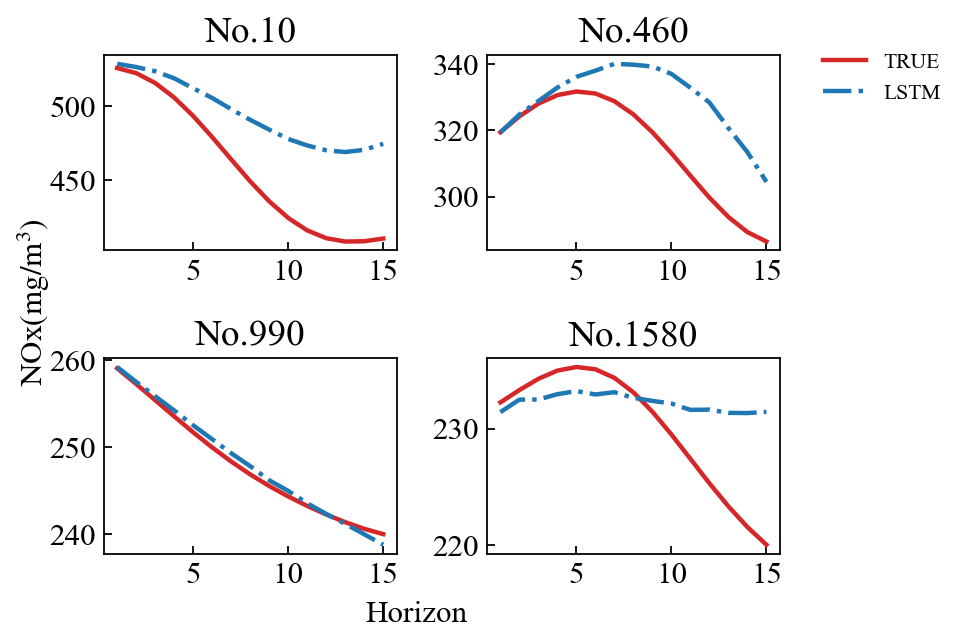

In [36]:
config = {
"font.family":'serif',  
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
x = np.arange(1,16)
fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)

points = [16000,18000,23000,25000]
point = points[0]
ax1[0,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,0].set_title('No.10')


point = points[1]
ax1[0,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[0,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)
ax1[0,1].set_title('No.460')

point = points[2]
ax1[1,0].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,0].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,0].set_title('No.990')

point = points[3]   # 1380
ax1[1,1].plot(x, y_true[point-1,:], color=color_list[4], linestyle='-', linewidth=2)
ax1[1,1].plot(x, y_pred[point-1,:], color=color_list[0], linestyle='-.', linewidth=2)

ax1[1,1].set_title('No.1580')
#ax1[1,1].set_ylim([290,320])

egend_font = {"family" : "serif"}
fig.legend(['TRUE', 'LSTM', ],frameon=False,\
           fontsize='x-small', bbox_to_anchor=(1.18, 0.92))

fig.text(0.5, 0, "Horizon", ha='center')
fig.text(0, 0.5, "NOx($\mathrm{mg/m^{3}}$)", va='center', rotation='vertical')   
plt.tight_layout()